## 1. Problem Description
We are tasked with predicting the next day's closing price of Tesla stock (TSLA) using historical stock data. The goal is to build a regression model to forecast future prices, leveraging features such as price change, moving averages, and volume changes. We will use both a Linear Regression model and a Random Forest Regressor to evaluate which model provides better predictions.


## 2. Exploratory Data Analysis (EDA)

In [2]:
import yfinance as yf
import pandas as pd


# AAPL stock data download
data = yf.download('AAPL', start='2014-01-01', end='2024-01-01')

#Resetting index to make 'Date' a column
data.reset_index(inplace=True)

#Display first few rows and check basic info
data.head()
data.info()
data.describe()


/Users/utente/Downloads/Ml_zoom_camp_project/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   (Date, )           2516 non-null   datetime64[ns]
 1   (Adj Close, AAPL)  2516 non-null   float64       
 2   (Close, AAPL)      2516 non-null   float64       
 3   (High, AAPL)       2516 non-null   float64       
 4   (Low, AAPL)        2516 non-null   float64       
 5   (Open, AAPL)       2516 non-null   float64       
 6   (Volume, AAPL)     2516 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 137.7 KB


Price,Date,Adj Close,Close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
count,2516,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03
mean,2018-12-31 00:18:53.227344896,75.614606,77.920721,78.704468,77.060193,77.856671,1.366662e+08
min,2014-01-02 00:00:00,15.572029,17.849285,17.911785,17.626785,17.684999,2.404830e+07
25%,2016-06-30 18:00:00,27.098965,29.803750,29.976250,29.554375,29.740001,8.138358e+07
50%,2019-01-01 00:00:00,45.867067,48.107500,48.535000,47.743750,47.963749,1.121606e+08
75%,2021-06-30 06:00:00,132.005909,134.562496,135.995003,133.325005,134.792496,1.668892e+08
max,2023-12-29 00:00:00,197.144180,198.110001,199.619995,197.000000,198.020004,1.065523e+09
std,NaN,56.454544,56.226768,56.808974,55.581734,56.171865,8.403551e+07


## Feature Engineering

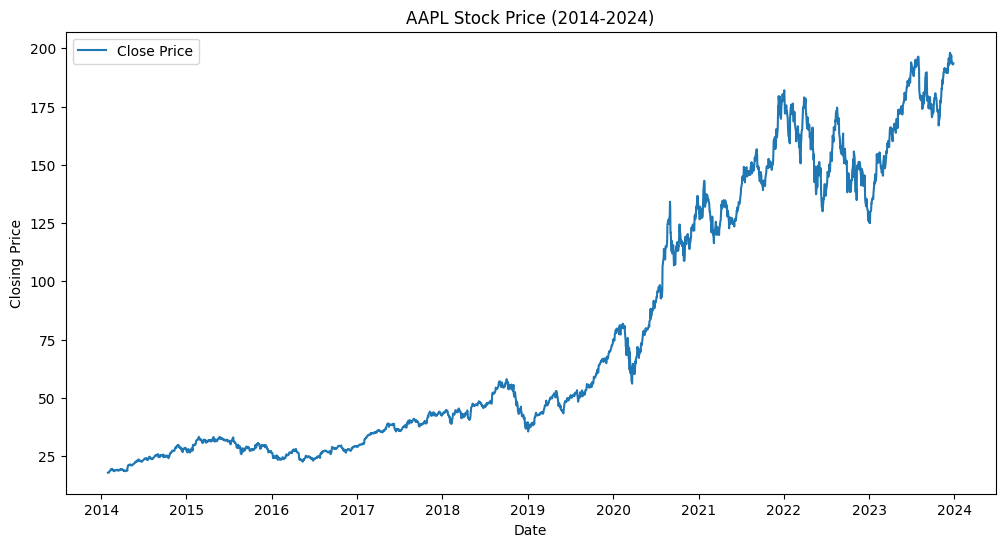

In [3]:
import matplotlib.pyplot as plt

# Calculate price change (difference between today's close and previous day's close)
data['Price_Change'] = data['Close'].diff()

# Calculate moving averages (5-day and 20-day)
data['MA5'] = data['Close'].rolling(window=5).mean()
data['MA20'] = data['Close'].rolling(window=20).mean()

# Calculate volume change (difference between today's volume and the 5-day moving average of volume)
data['Volume_Change'] = data['Volume'] - data['Volume'].rolling(window=5).mean()

# Create the 'Next_Day_Close' column by shifting 'Close' by 1 day
data['Next_Day_Close'] = data['Close'].shift(-1)

# Drop rows with NaN values (required for moving averages and 'Next_Day_Close')
data.dropna(inplace=True)

# Visualize closing price over time
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'], label='Close Price')
plt.title('AAPL Stock Price (2014-2024)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


## 3. Model Training

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

#features (X) and target (y)
X = data[['Price_Change', 'MA5', 'MA20', 'Volume_Change']] 
y = data['Next_Day_Close']  # Target is the next day's closing price



#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

#Initialize models
linear_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=500, random_state=42)

#Cross-validation
lr_cv_scores = cross_val_score(linear_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

#Train the models
linear_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)


#Make predictions
lr_pred = linear_model.predict(X_test)
rf_pred = rf_model.predict(X_test)


print(f"Linear Regression CV Mean Squared Error: {-lr_cv_scores.mean()}")
print(f"Random Forest CV Mean Squared Error: {-rf_cv_scores.mean()}")



Linear Regression CV Mean Squared Error: 2.546118491095518
Random Forest CV Mean Squared Error: 623.807719729055


## 4. Model Evaluation

In [5]:
from sklearn.model_selection import KFold
import numpy as np

#Initialize k-fold cross-validator
k = 5  
kf = KFold(n_splits=k, shuffle=False)  

# Initialize models
#linear_model = LinearRegression()
#rf_model = RandomForestRegressor(n_estimators=500, random_state=42)

# Step 2: Perform k-fold cross-validation
lr_mse_scores = []
lr_r2_scores = []
rf_mse_scores = []
rf_r2_scores = []

for train_index, val_index in kf.split(X):
    # Split the data into training and validation sets
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Train Linear Regression
    linear_model.fit(X_train, y_train)
    lr_val_pred = linear_model.predict(X_val)
    
    # Evaluate Linear Regression
    lr_mse_scores.append(mean_squared_error(y_val, lr_val_pred))
    lr_r2_scores.append(r2_score(y_val, lr_val_pred))
    
    # Train Random Forest
    rf_model.fit(X_train, y_train)
    rf_val_pred = rf_model.predict(X_val)
    
    # Evaluate Random Forest
    rf_mse_scores.append(mean_squared_error(y_val, rf_val_pred))
    rf_r2_scores.append(r2_score(y_val, rf_val_pred))

# Step 3: Calculate average metrics for each model
lr_avg_mse = np.mean(lr_mse_scores)
lr_avg_r2 = np.mean(lr_r2_scores)
rf_avg_mse = np.mean(rf_mse_scores)
rf_avg_r2 = np.mean(rf_r2_scores)

# Display results
print("Linear Regression k-Fold Cross-Validation Results:")
print(f"Average MSE: {lr_avg_mse:.2f}")
print(f"Average R²: {lr_avg_r2:.2f}")

print("\nRandom Forest k-Fold Cross-Validation Results:")
print(f"Average MSE: {rf_avg_mse:.2f}")
print(f"Average R²: {rf_avg_r2:.2f}")

# Step 8: Interpretation
print("\nInterpretation:")
if -lr_cv_scores.mean() < -rf_cv_scores.mean():
    print("Linear Regression has a lower mean squared error than Random Forest.")
else:
    print("Random Forest has a lower mean squared error than Linear Regression.")


Linear Regression k-Fold Cross-Validation Results:
Average MSE: 4.40
Average R²: 0.98

Random Forest k-Fold Cross-Validation Results:
Average MSE: 35.28
Average R²: 0.80

Interpretation:
Linear Regression has a lower mean squared error than Random Forest.


## 5. True vs Predicted Prices Visualization

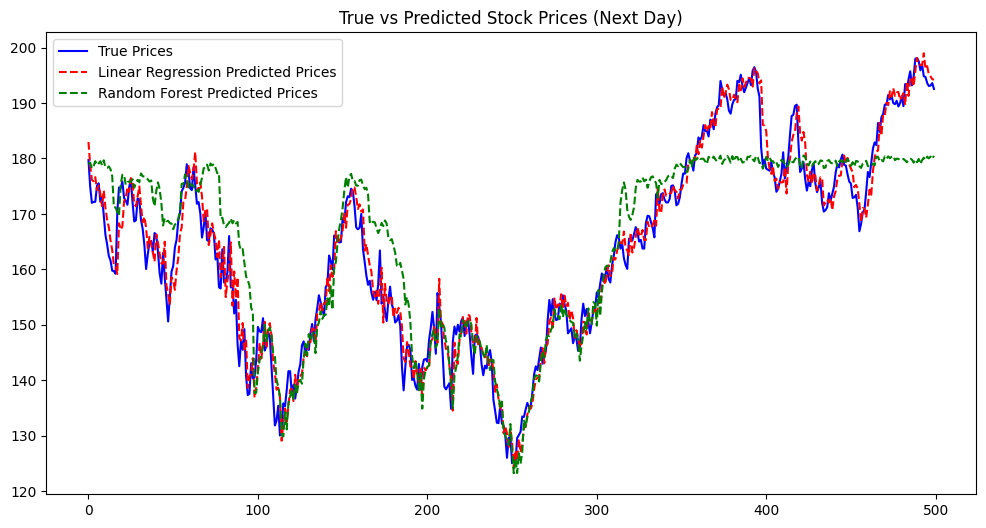

In [6]:
# Step 11: Visualize the true vs predicted stock prices

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True Prices', color='blue')
plt.plot(lr_pred, label='Linear Regression Predicted Prices', color='red', linestyle='--')
plt.plot(rf_pred, label='Random Forest Predicted Prices', color='green', linestyle='--')
plt.legend()
plt.title('True vs Predicted Stock Prices (Next Day)')
plt.show()


In [7]:
#Step 11: Make a prediction with a new data point
# Let's take the most recent day in the dataset (the last row in the dataset) for prediction.
latest_data = data.iloc[-1][['Price_Change', 'MA5', 'MA20', 'Volume_Change']].values.reshape(1, -1)

# Predict the next day's closing price using both models
lr_next_day_pred = linear_model.predict(latest_data)
rf_next_day_pred = rf_model.predict(latest_data)

print(f"Linear Regression Prediction for Next Day's Close: {lr_next_day_pred[0]}")
print(f"Random Forest Prediction for Next Day's Close: {rf_next_day_pred[0]}")


Linear Regression Prediction for Next Day's Close: 194.18028166444066
Random Forest Prediction for Next Day's Close: 180.32619747924804


In [8]:
data.tail(5)

Price,Date,Adj Close,Close,High,Low,Open,Volume,Price_Change,MA5,MA20,Volume_Change,Next_Day_Close
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,
2510,2023-12-21,193.730881,194.679993,197.080002,193.500000,196.100006,46482500,-0.150009,195.982001,193.487000,-18207100.0,193.600006
2511,2023-12-22,192.656189,193.600006,195.410004,192.970001,195.179993,37122800,-1.079987,195.188000,193.668501,-9340020.0,193.050003
2512,2023-12-26,192.108841,193.050003,193.889999,192.830002,193.610001,28919300,-0.550003,194.620001,193.831501,-12177000.0,193.149994
2513,2023-12-27,192.208359,193.149994,193.500000,191.089996,192.490005,48087700,0.099991,193.862000,193.969001,5516680.0,193.580002
2514,2023-12-28,192.636261,193.580002,194.660004,193.169998,194.139999,34049900,0.430008,193.612000,194.179501,-4882540.0,192.529999


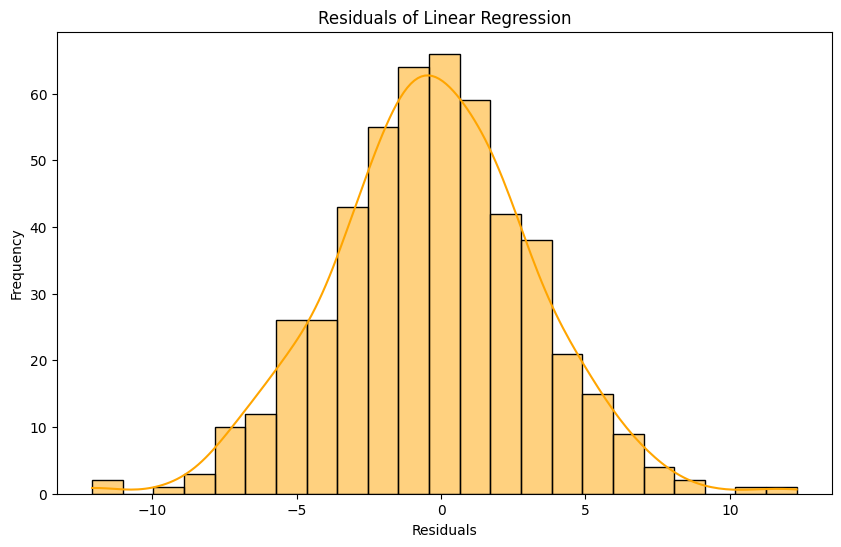

In [9]:
# Plot residuals to check for patterns
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate residuals
residuals = y_test - lr_pred

# Plot residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='orange')
plt.title('Residuals of Linear Regression')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


In [10]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Define a dictionary to hold the models and their hyperparameters
models = {
    'L1 (Lasso)': Lasso(alpha=0.1, random_state=42),
    'L2 (Ridge)': Ridge(alpha=0.1, random_state=42),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42),  # l1_ratio = 0.5 combines L1 and L2
    'Stochastic (SGD)': SGDRegressor(penalty='l2', alpha=0.1, max_iter=1000, random_state=42)  # Default is L2 regularization
}

# Initialize lists to store results
results = []

# Loop through each model, fit, and evaluate
for name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store the results
    results.append({'Model': name, 'MSE': mse, 'R²': r2})

# Convert results to a DataFrame for easier comparison
results_df = pd.DataFrame(results)

# Display the results
print(results_df)


              Model           MSE            R²
0        L1 (Lasso)  1.218180e+01  9.610496e-01
1        L2 (Ridge)  1.195980e+01  9.617595e-01
2        ElasticNet  1.211460e+01  9.612645e-01
3  Stochastic (SGD)  1.059731e+46 -3.388405e+43


In [11]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Define a range of alpha values to tune
alphas = [0.01, 0.1, 1, 10, 100]

# Initialize a list to store results
ridge_results = []

# Loop through each alpha value
for alpha in alphas:
    # Initialize Ridge with the current alpha
    ridge = Ridge(alpha=alpha, random_state=42)
    
    # Fit the model on the training data
    ridge.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = ridge.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store the results
    ridge_results.append({
        'Alpha': alpha,
        'MSE': mse,
        'R²': r2
    })

# Convert results to a DataFrame for easier analysis
ridge_results_df = pd.DataFrame(ridge_results)

# Sort results by MSE
ridge_results_df = ridge_results_df.sort_values(by='MSE').reset_index(drop=True)

# Display the results
print(ridge_results_df)

    Alpha        MSE        R²
0    0.01  11.959769  0.961760
1    0.10  11.959805  0.961759
2    1.00  11.960164  0.961758
3   10.00  11.963809  0.961747
4  100.00  12.005242  0.961614


In [12]:
from sklearn.model_selection import cross_val_score




#Initialize a list to store cross-validation results
cv_results = []

# Step 3: Perform cross-validation for each alpha value
#for alpha in alphas:
    # Initialize Ridge Regression with the current alpharidge = Ridge(alpha=0.01, random_state=42)
    
    # Perform 5-fold cross-validation
cv_mse = cross_val_score(ridge, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_r2 = cross_val_score(ridge, X_train, y_train, cv=5, scoring='r2')
    
    # Calculate the mean of the cross-validation scores
mean_mse = -cv_mse.mean()  # Convert negative MSE to positive
mean_r2 = cv_r2.mean()
    
    # Store the results
cv_results.append({
        'Alpha': 0.01,
        'Mean CV MSE': mean_mse,
        'Mean CV R²': mean_r2
    })

# Convert results to a DataFrame for easier analysis
cv_results_df = pd.DataFrame(cv_results)

# Sort results by Mean CV MSE
cv_results_df = cv_results_df.sort_values(by='Mean CV MSE').reset_index(drop=True)

# Display the cross-validation results
print(cv_results_df)


   Alpha  Mean CV MSE  Mean CV R²
0   0.01     2.555092    0.982044


In [13]:
#Select the best alpha
best_alpha = cv_results_df.loc[0, 'Alpha']

#Train the Ridge model with the best alpha
ridge_model = Ridge(alpha=best_alpha, random_state=42)
ridge_model.fit(X_train, y_train)

#Make predictions on the test set
ridge_predictions = ridge_model.predict(X_test)

#Evaluate the model on the test set
ridge_mse = mean_squared_error(y_test, ridge_predictions)
ridge_r2 = r2_score(y_test, ridge_predictions)

print(f"Best Alpha: {best_alpha}")
print(f"Test Set MSE: {ridge_mse}")
print(f"Test Set R²: {ridge_r2}")


Best Alpha: 0.01
Test Set MSE: 11.95976883474837
Test Set R²: 0.9617595822222982


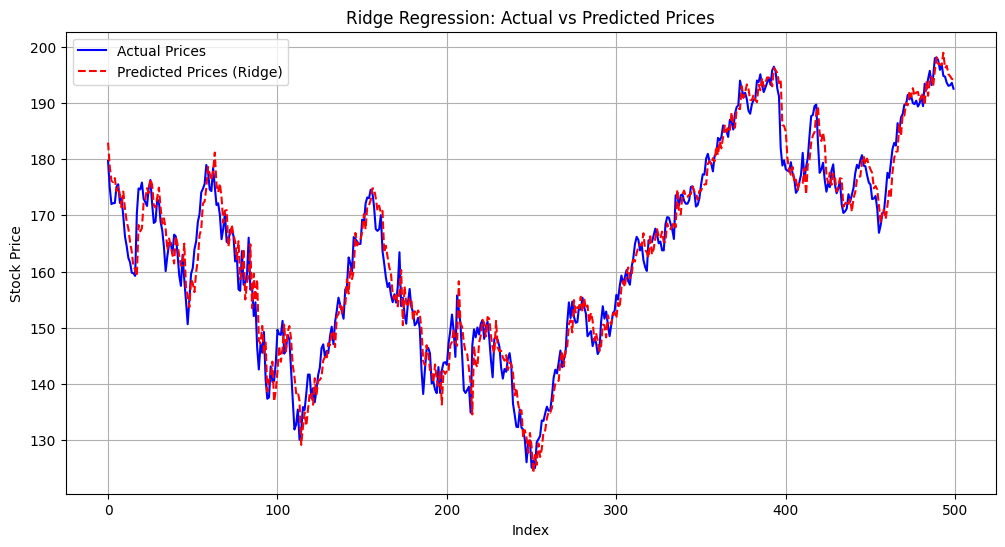

In [14]:
import matplotlib.pyplot as plt

# Plot true vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Prices', color='blue')
plt.plot(ridge_predictions, label='Predicted Prices (Ridge)', color='red', linestyle='--')
plt.title('Ridge Regression: Actual vs Predicted Prices')
plt.xlabel('Index')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
# Step 11: Make a prediction with a new data point (example)
# Take the most recent day in the dataset (second-to-last row) for prediction
latest_data = data.iloc[-2][['Price_Change', 'MA5', 'MA20', 'Volume_Change']].values.reshape(1, -1)

# Predict the next day's closing price using the trained Ridge model
ridge_next_day_pred = ridge_model.predict(latest_data)

print(f"Ridge Regression Prediction for Next Day's Close: {ridge_next_day_pred[0]}")


Ridge Regression Prediction for Next Day's Close: 194.28485199262047


In [16]:
# Predict using Linear Regression
lr_next_day_pred = linear_model.predict(latest_data)

# Predict using Random Forest
rf_next_day_pred = rf_model.predict(latest_data)

# Print predictions
print(f"Linear Regression Prediction for Next Day's Close: {lr_next_day_pred[0]}")
print(f"Random Forest Prediction for Next Day's Close: {rf_next_day_pred[0]}")
print(f"Ridge Regression Prediction for Next Day's Close: {ridge_next_day_pred[0]}")


Linear Regression Prediction for Next Day's Close: 194.28484831912596
Random Forest Prediction for Next Day's Close: 179.74867831420897
Ridge Regression Prediction for Next Day's Close: 194.28485199262047


In [17]:
data = {
    'Price_Change': -0.585, 
    'MA5': 85.23, 
    'MA20': 16.500, 
    'Volume_Change': -500000
    }


In [18]:
test_data = pd.Series(data).to_numpy().reshape(1, -1)

In [19]:

float(model.predict(test_data)[0])

-3.2930913775109753e+21

In [22]:
import requests
url = 'http://localhost:9990/predict'

In [24]:
response = requests.post(url, json = data).json()

In [26]:
data, print(response)

{'prediction': 93.71636720638779}


({'Price_Change': -0.585,
  'MA5': 85.23,
  'MA20': 16.5,
  'Volume_Change': -500000},
 None)